In [1]:
import sys
sys.path.append('/home/hsher/Metadensity/scripts/')
from dataloader import *
from annoloader import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import deepdish as dd
from heatmap_util import *
import os
base_dir = '/home/hsher/densities'
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


## load metadata

In [2]:
# find proteins with density precomputed
uids = [f.split('_')[0] for f in os.listdir(base_dir) if 'ridensityarr' in f]

with_data = master_df.set_index('uid').loc[uids]

In [3]:
hepg2_uids = with_data.loc[with_data['Cell line'] == 'HepG2']
hepg2_uids.drop_duplicates(subset = ['RBP'], inplace = True)
k562_uids = with_data.loc[with_data['Cell line'] == 'K562']
k562_uids.drop_duplicates(subset = ['RBP'], inplace = True)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
df, flen = into_one_df(hepg2_uids.index.tolist()+k562_uids.index.tolist(), generic_rna+branchpoints, suffix = 'ridensityarr', stat = np.nanmedian)
# set index to RBP
df.index = master_df.set_index('uid').loc[df.index, 'RBP']

/home/hsher/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [8]:
# calculate correlation distance between proteins
import scipy
corr = scipy.spatial.distance.pdist(df,'cosine')

In [9]:
import seaborn as sns
square_corr = pd.DataFrame(scipy.spatial.distance.squareform(corr), index = df.index, columns = df.index)

In [10]:
complex_subset=['Spliceosome', 'A complex', 'B complex', 'C complex', 'P complex','17S U2 snRNP',
              'Polymerase Ser5P Interactome','Polymerase Ser7P Interactome','Polymerase Tyr1P Interactome','Polymerase Thr4P Interactome','Polymerase Ser2P Interactome',
              'Ribosome Interactome Direct', 'stress granule or p-body']

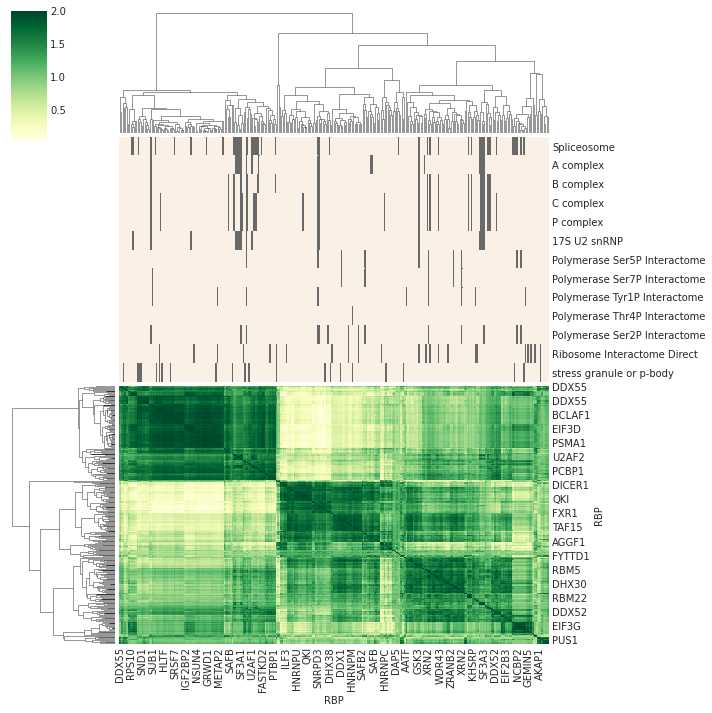

In [13]:
%matplotlib inline
sns.clustermap(2-square_corr, cmap = 'YlGn', col_colors = rbp_complex_color[complex_subset])

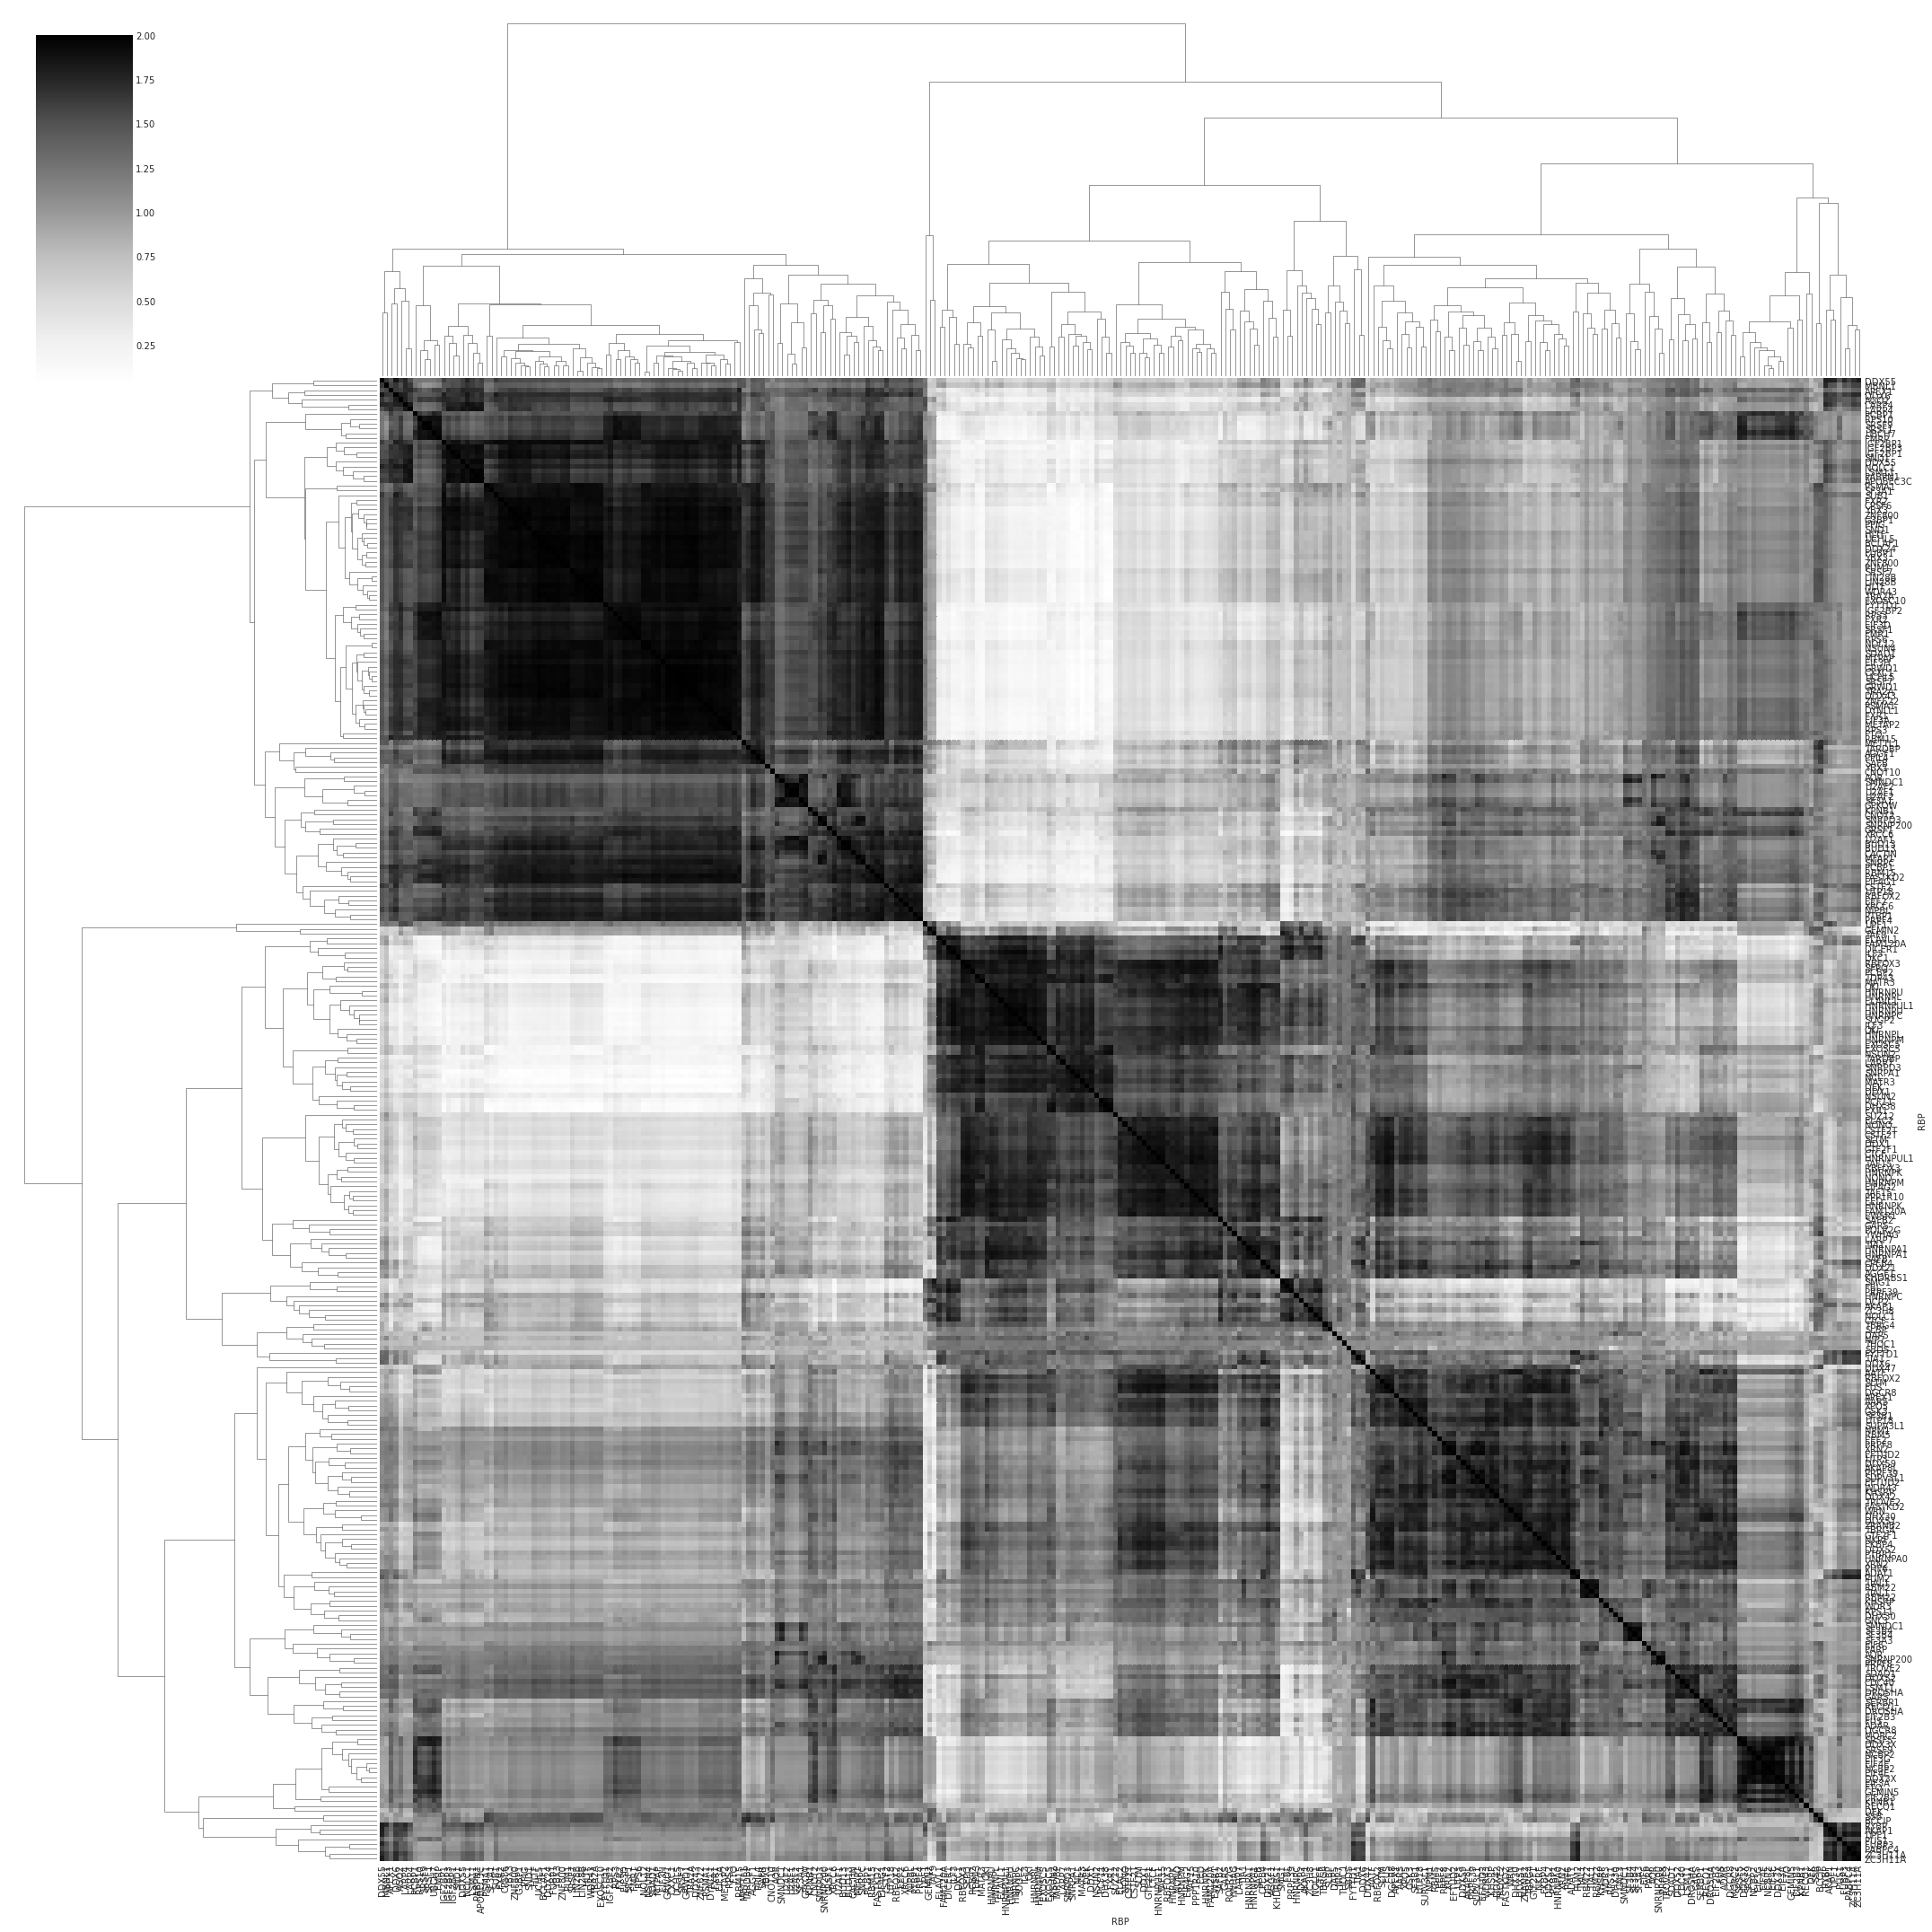

In [41]:
g = sns.clustermap(2-square_corr, cmap = 'Greys', xticklabels = 1, yticklabels = 1, figsize = (30,30))

In [51]:
import scipy.cluster.hierarchy as sch
df = 2-square_corr
# retrieve clusters using fcluster 
d = sch.distance.pdist(df)
L = sch.linkage(d)
clusters = sch.fcluster(L, 0.2*df.max().max(), 'distance')
# clusters indicices correspond to incides of original df
for i,cluster in enumerate(clusters):
    #rbp = df.index[g.dendrogram_col.reordered_ind[i]]
    rbp = df.index[i]
    print(rbp, cluster)

SNRNP200 280
CSTF2T 103
SUPV3L1 150
TRA2A 230
FTO 252
SLTM 101
DICER1 176
ELAVL1 119
HNRNPK 96
ILF3 70
PTBP1 261
PRPF4 262
U2AF1 268
DHX38 74
SRSF9 207
PRPF39 152
WDR43 230
EIF4E 21
DEK 77
SFPQ 107
HLTF 240
NKRF 163
ZNF800 232
AQR 186
LARP4 197
DYNLL1 219
SRSF7 245
DDX59 137
PPP1R10 94
SSB 1
SF3B4 67
EXOSC5 72
SNRPA1 79
HNRNPA1 123
ZC3H11A 15
CDC40 45
TIAL1 175
DDX3X 22
UTP18 274
G3BP1 229
PABPN1 203
QKI 120
FUS 131
KPNB1 286
DDX52 49
SMNDC1 179
SF3A1 191
EFTUD2 151
RBFOX2 134
APEX1 293
EEF2 263
EIF3H 243
SUGP2 113
PCBP2 108
HNRNPU 116
PCF11 76
DROSHA 47
SF3A3 68
MATR3 81
BCLAF1 231
GARS 48
FXR2 241
TIA1 3
DKC1 71
LSM11 205
PRPF8 281
NCBP2 21
DGCR8 128
EIF3A 242
IGF2BP1 213
NIP7 12
NOL12 215
SRSF1 208
RBM15 201
DDX1 78
RBFOX3 88
TARDBP 85
HNRNPM 111
GRWD1 223
TBRG4 7
XRCC6 264
HNRNPC 115
FAM120A 90
FXR1 75
FYTTD1 298
XPO5 141
CSTF2 275
CTCF 98
PCBP1 284
BUD13 193
NOLC1 37
LARP7 180
PSMA1 237
HNRNPUL1 92
SUB1 255
EIF2B3 32
AGGF1 269
DHX30 62
DDX55 184
YBX1 288
GTF2F1 165
UCHL5 223
FKBP4

In [12]:
def load_metadensity(uid, basedir = base_dir, suffix='truncatearr',
                     background_method = 'subtract', normalize = True):
    ''' load it back so we can use the plotting function from metadensity'''
    
    try:
        row = encode4_data.loc[encode4_data['uid']==uid].iloc[0]
        e = eCLIP.from_series(row, single_end = True)
        cell_line = row['Cell line']
    except:
        row = encode_data.loc[encode_data['uid']==uid].iloc[0]
        e = eCLIP.from_series(row)
        cell_line = row['Cell line']
    
    den = Metatruncate(e, name = f'{e.name}({cell_line})' , 
                        deep_dish_path = os.path.join(basedir, f'{uid}_{suffix}.h5'),
                        background_method = background_method, normalize = normalize)
    return den
    

In [35]:
def get_rbp_colors(all_meta):
    rbps = [n.name.split('(')[0] for n in all_meta]
    rbps.sort()
    colors = auto_rbp_color(rbps)
    # remap
    color_dict = {}
    for m in all_meta:
        color_dict[m.name] = colors[m.name.split('(')[0]]
    return color_dict


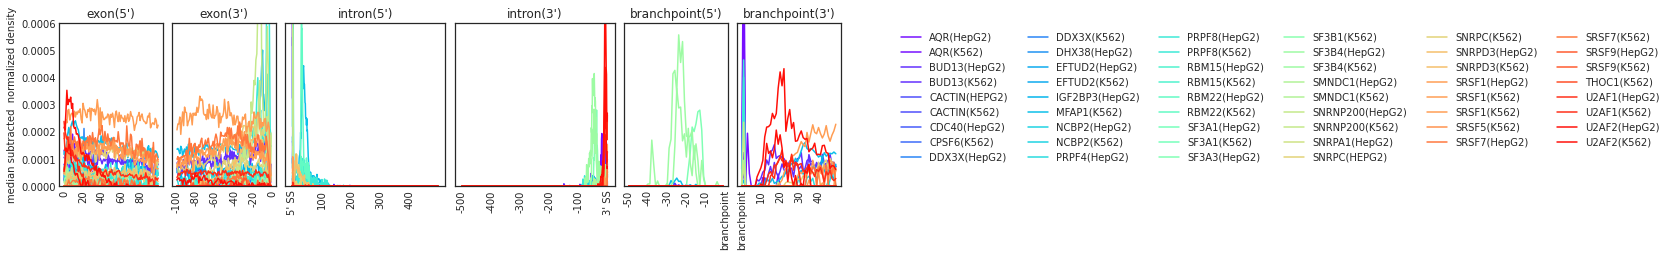

In [13]:
splice_uids = master_df.loc[master_df['RBP'].isin(rbp_complex.loc[rbp_complex['Spliceosome']].index), 'uid']
all_meta = sorted([load_metadensity(uid) for uid in splice_uids], key = lambda x: x.name)
f = plot_mean_density(all_meta, smooth = False, features_to_show=['exon', 'intron', 'branchpoint'], stat = 'median', ymax = 0.0006, plot_std = False, color_dict = get_rbp_colors(all_meta))

Text(0.5, 0.98, 'A Complex/17S U2 snRNP')

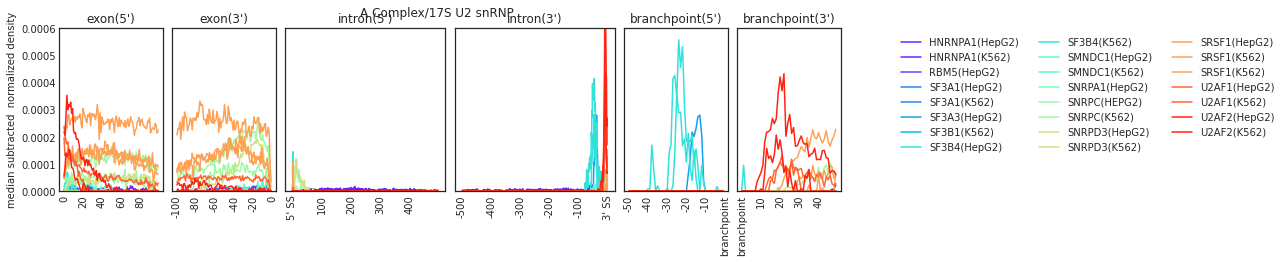

In [14]:
splice_uids = master_df.loc[master_df['RBP'].isin(
    rbp_complex.loc[(rbp_complex['A complex'])|(rbp_complex['17S U2 snRNP'])].index), 'uid']
all_meta = sorted([load_metadensity(uid) for uid in splice_uids], key = lambda x: x.name)
f = plot_mean_density(all_meta, smooth = False, features_to_show=['exon', 'intron', 'branchpoint'], stat = 'median', ymax = 0.0006, plot_std = False, color_dict = get_rbp_colors(all_meta))
plt.suptitle('A Complex/17S U2 snRNP')

Text(0.5, 0.98, 'B,C,P Complex')

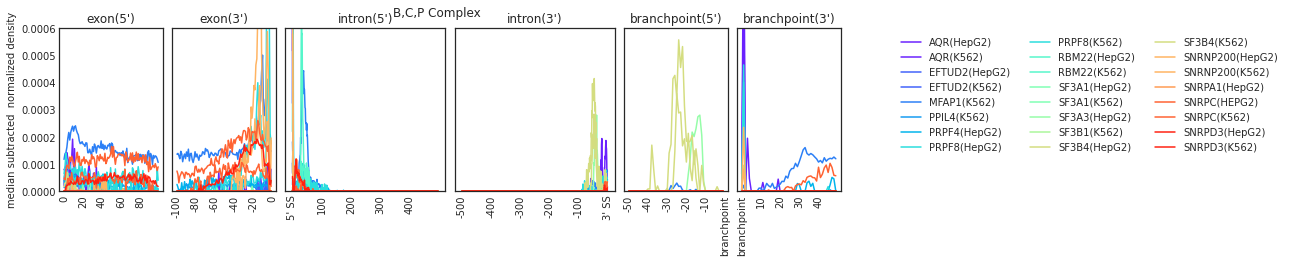

In [15]:
splice_uids = master_df.loc[master_df['RBP'].isin(
    rbp_complex.loc[(rbp_complex['B complex'])].index), 'uid']
all_meta = sorted([load_metadensity(uid) for uid in splice_uids], key = lambda x: x.name)
f = plot_mean_density(all_meta, smooth = False, features_to_show=['exon', 'intron', 'branchpoint'], stat = 'median', ymax = 0.0006, plot_std = False, color_dict = get_rbp_colors(all_meta))
plt.suptitle('B,C,P Complex')

(array([ 731.,  940., 1039., 1162., 1222., 1155.,  791.,  761.,  673.,
         437.]),
 array([0.00899485, 0.20458981, 0.40018477, 0.59577973, 0.79137469,
        0.98696965, 1.1825646 , 1.37815956, 1.57375452, 1.76934948,
        1.96494444]),
 <BarContainer object of 10 artists>)

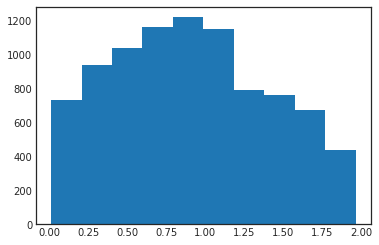

In [36]:
plt.hist(corr)

In [78]:
# identify new splicesome proteins
known_spliceosome = rbp_complex.loc[rbp_complex['Spliceosome']].index
med_distance_to_spliceosome = square_corr.loc[square_corr.index.isin(known_spliceosome)].median(axis = 0)
close_to_spliceosome = med_distance_to_spliceosome[med_distance_to_spliceosome<0.6].index

In [67]:
square_corr.loc[square_corr.index.isin(known_spliceosome)].median(axis = 0)

RBP
SNRNP200    0.698399
CSTF2T      1.140803
SUPV3L1     0.595012
TRA2A       0.642892
FTO         0.570308
              ...   
EIF3D       0.562301
AKAP1       1.061854
SNRPD3      1.247579
TAF15       1.176933
PPIG        0.628811
Length: 134, dtype: float64

<AxesSubplot:>

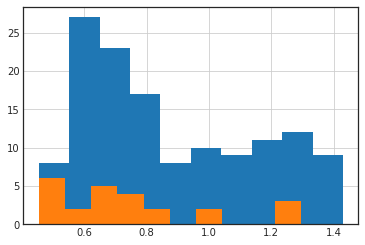

In [73]:
med_distance_to_spliceosome.hist()
med_distance_to_spliceosome.loc[med_distance_to_spliceosome.index.isin(known_spliceosome)].hist()

In [79]:
new

{0.4534914509832553,
 0.4718148631116282,
 0.48918980384438204,
 0.48968341392681286,
 0.49061774908762773,
 0.496107453039576,
 0.5176287303485431,
 0.5337591152798442,
 0.5623006446005839,
 0.5657907866983901,
 0.5703080519599735,
 0.5774447226673896,
 0.5924418333165187,
 0.5949340880445915,
 0.5950119427767601,
 0.596578422402712,
 0.5978432781707043}

Text(0.5, 0.98, 'RBP with similar distribution to known spliceosome proteins')

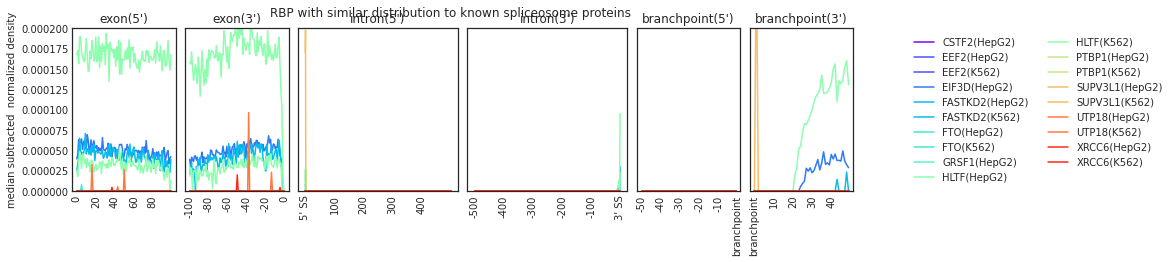

In [82]:
new = set(close_to_spliceosome)-set(known_spliceosome)
splice_uids = master_df.loc[master_df['RBP'].isin(
    new), 'uid']
all_meta = sorted([load_metadensity(uid) for uid in splice_uids], key = lambda x: x.name)
f = plot_mean_density(all_meta, smooth = False, features_to_show=['exon', 'intron', 'branchpoint'], stat = 'median', ymax = 0.0002, plot_std = False, color_dict = get_rbp_colors(all_meta))
plt.suptitle('RBP with similar distribution to known spliceosome proteins')

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/seaborn-0.11.0-py3.7.egg/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


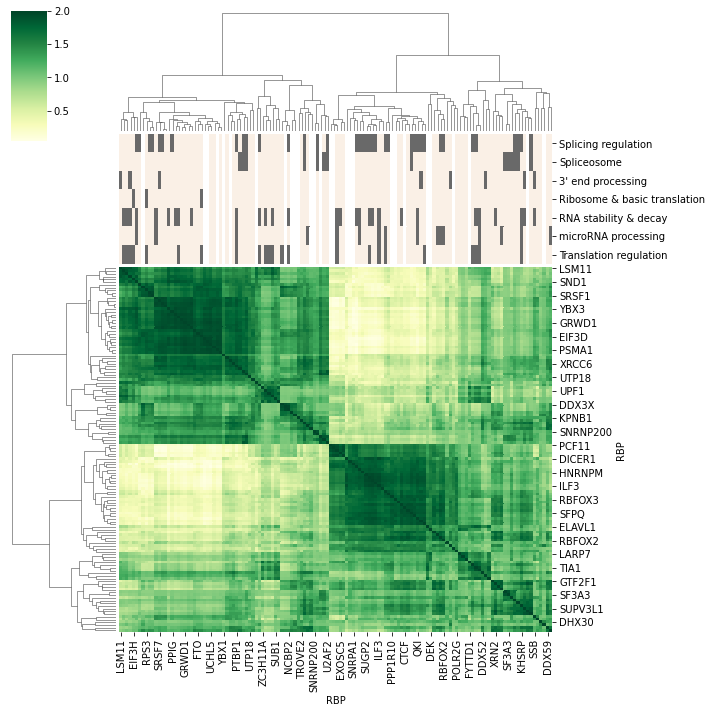

In [10]:
sns.clustermap(2-square_corr, cmap = 'YlGn', col_colors = rbp_class_color[subset])

## Load string network

In [52]:
string = pd.read_pickle('~/projects/RBP_annot/string_rbp_in.pickle')

In [53]:
bioplex = pd.read_pickle('~/projects/RBP_annot/bioplex_rbp_in.pickle')

## load precomputed mean metadensity

In [64]:
from metadensity.plotd import *
def read_precomputed_array(uid, base_dir = base_dir, suffix = 'densityarr'):
    ''' load deep dish h5 into data structure'''
    return dd.io.load(os.path.join(base_dir, '{}_{}.h5'.format(uid, suffix)))
def get_feature_length(denarray):
    ''' return feature length for each feature in dictionary'''
    features = list(set([d[0] for d in denarray.keys()]))
    feature_len = [denarray[f, 'left', 'rep1'].shape[1] for f in features]
    return dict(zip(features, feature_len))
def merge_two_reps(denarray, features = generic_rna, stat = np.nanmean):
    ''' merge two rep, return mean/median density'''
    all_values = []
    for f in features:
        for align in ['left', 'right']:
            
            rep1 = denarray[f, align, 'rep1']
            rep2 = denarray[f, align, 'rep2']
            
            all_den = np.concatenate([rep1,rep2], axis = 0) # concat into 1 array
            values = stat(all_den, axis = 0)
            all_values.append(values)
    return(np.concatenate(all_values))
def into_one_df(uids, features = generic_rna, base_dir = base_dir, suffix = 'densityarr', stat = np.nanmean):
    ''' given a list of uid, concat all features and data into 1 df'''
    all_vector = []
    i = 0
    for uid in uids:
        denarray = read_precomputed_array(uid, base_dir = base_dir, suffix = suffix)
        if i == 0:
            flen = get_feature_length(denarray)
        all_vector.append(merge_two_reps(denarray, features, stat = stat)) # append into results
        i+=1
    
    
    
    df = pd.DataFrame(np.stack(all_vector), index = master_df.set_index('uid').loc[uids, 'RBP'].tolist())
    df.fillna(0, inplace = True)
    df.replace(np.nan, 0, inplace = True)
    
    return df , flen

def get_feat_color(features, flen):
    ''' generate color annotation for heatmap'''
    # get feature length
    colors = []
    names = []
    for f in features:
        length = flen[f]
        name = key_to_name[f]
        
        for align in ['start', 'end']:
            color_key = '{} {}'.format(name, align)
            names.append(color_key)
            colors += [color_dict[color_key]]*length
        
    return colors, names

In [68]:
# make into dataframe

df, flen = into_one_df(hepg2_uids.index.tolist()+k562_uids.index.tolist(), suffix = 'ridensityarr')

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [72]:
# average between cell line
df = df.reset_index().groupby(by = 'index').mean()

In [76]:
df.index

Index(['AARS', 'AATF', 'ADAR', 'ADAT1', 'AGGF1', 'AGO2', 'AKAP1', 'AKAP8L',
       'APEX1', 'APOBEC3C',
       ...
       'XRCC6', 'XRN2', 'YBX1', 'YBX3', 'YWHAG', 'ZC3H11A', 'ZC3H8', 'ZNF622',
       'ZNF800', 'ZRANB2'],
      dtype='object', name='index', length=214)

# visualize some pairs in clique!

In [155]:
from scipy.spatial.distance import *
from itertools import combinations 
from random import sample 
from scipy.stats import ks_2samp
import seaborn as sns
def metadensity_distance(pairs, density_df = df, metric = correlation):
    ''' return metadensity eucledian distance between pairs of protein'''
    den1 = density_df.loc[pairs[0]]
    den2 = density_df.loc[pairs[1]]
    
    return(metric(den1, den2))

def generate_pairs(ppi, df = df, colnames = ['protein_one_rbp', 'protein_two_rbp']):
    ''' generate paris for evaluation'''
    itxn_pairs = ppi[colnames].drop_duplicates()
    itxn_pairs = itxn_pairs.loc[(itxn_pairs[colnames[0]].isin(df.index)) & (itxn_pairs[colnames[1]].isin(df.index))]

    # create a shuffled bait
    unique_rbp = set(ppi[colnames[0]]).union(set(ppi[colnames[1]]))
    all_possible_itxn = set(combinations(set(df.index).intersection(unique_rbp),2))
    non_itxn_pair = all_possible_itxn - set([tuple(r) for r in itxn_pairs.to_numpy()])
    
    
    non_itxn_df = pd.DataFrame(non_itxn_pair, columns = colnames)
    
    return itxn_pairs, non_itxn_df
def generate_pairs_kris(ppi, colnames = ['Bait', 'Prey']):
    ''' generate paris for evaluation, Kris bait have not cover the entire RBPome'''
    itxn_pairs = ppi[colnames].drop_duplicates()
    itxn_pairs = itxn_pairs.loc[(itxn_pairs[colnames[0]].isin(df.index)) & (itxn_pairs[colnames[1]].isin(df.index))]
    
    # create a shuffled bait
    all_possible_itxn = set(combinations(df.index,2))
    non_itxn_pair = all_possible_itxn - set([tuple(r) for r in itxn_pairs.to_numpy()])
    
    # filter for bait
    non_itxn_df = pd.DataFrame(non_itxn_pair, columns = colnames)
    non_itxn_df = non_itxn_df.loc[(non_itxn_df['Bait'].isin(ppi['Bait']))&(non_itxn_df['Prey'].isin(ppi['Prey']))]
    
    
    return itxn_pairs, non_itxn_df

def compare_pair_distance(pos, neg, dist_ma = correlation, metaden = df):
    itxn_pair_dist = [metadensity_distance(pos.loc[i].tolist(), metaden, dist_ma) for i in pos.index]
    nonitxn_pair_dist = [metadensity_distance(neg.loc[i].tolist(), metaden, dist_ma) for i in neg.index]
    
    data = pd.DataFrame([itxn_pair_dist+nonitxn_pair_dist, ['ppi_edge']*len(itxn_pair_dist)+['non_ppi_edge']*len(nonitxn_pair_dist)], index = ['dist', 'edge_type']).T
    data['dist'] = data['dist'].astype(float)
    
    return data
    

In [142]:
itxn_pairs, non_itxn_pair = generate_pairs(string)
string_data = compare_pair_distance(itxn_pairs, non_itxn_pair, dist_ma = cosine, metaden = df)

In [143]:
itxn_pairs_bp, non_itxn_pair_bp = generate_pairs(bioplex, colnames = ['SymbolA', 'SymbolB'])
bioplex_data = compare_pair_distance(itxn_pairs_bp, non_itxn_pair_bp, dist_ma = cosine)

In [144]:
biogrid = pd.read_pickle('~/projects/RBP_annot/biogrid.pickle')
biogrid=biogrid.loc[biogrid['OFFICIAL_SYMBOL_A']!=biogrid['OFFICIAL_SYMBOL_B']]
itxn_pairs_bg, non_itxn_pair_bg = generate_pairs(biogrid, colnames = ['OFFICIAL_SYMBOL_A', 'OFFICIAL_SYMBOL_B'])
biogrid_data = compare_pair_distance(itxn_pairs_bg, non_itxn_pair_bg, dist_ma = cosine, metaden=df)


In [152]:
def asterstick(pval):
    if pval > 0.05:
        return ''
    elif pval >0.001:
        return '*'
    elif pval > 0.0001:
        return '**'
    else:
        return '***'
def violinplot_w_pval(data, ax, title):
    sns.violinplot(data = data, y = 'dist', x = 'edge_type', ax = ax, palette="Set2")

    s, pval = ks_2samp(data.loc[data['edge_type']=='ppi_edge', 'dist'],
                       data.loc[data['edge_type']!='ppi_edge','dist']
                       , alternative = "greater") # if itxn pair distance is less than non-interacting pairs
    ax.text(1,1.9,asterstick(pval))
    ax.set_xticklabels(['TRUE', 'FALSE'])
    ax.set_xlabel('is PPI')
    ax.set_ylabel('cosine distance')
    ax.set_title(title)
def ecdf_w_pval(data, ax, title):
    sns.ecdfplot(data = data, y = 'dist', hue = 'edge_type', ax = ax, palette="Set2")

    s, pval = ks_2samp(data.loc[data['edge_type']=='ppi_edge', 'dist'],
                       data.loc[data['edge_type']!='ppi_edge','dist']
                       , alternative = "greater") # if itxn pair distance is less than non-interacting pairs
    ax.text(0.5,0.7,asterstick(pval))
    
    
    ax.set_ylabel('Consine distance')
    ax.set_title(title)


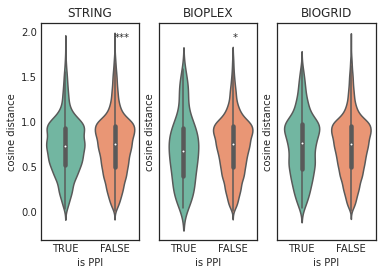

In [145]:
f, axes = plt.subplots(1,3, sharey = True)
for ax, data, name in zip(axes,[string_data, bioplex_data, biogrid_data], ['STRING', 'BIOPLEX', 'BIOGRID']):
    violinplot_w_pval(data, ax, name)


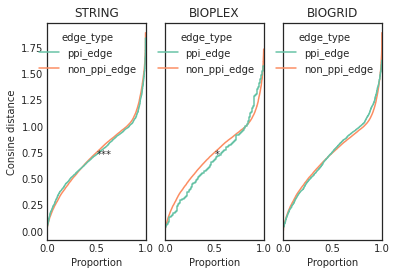

In [153]:
f, axes = plt.subplots(1,3, sharey = True)
for ax, data, name in zip(axes,[string_data, bioplex_data, biogrid_data], ['STRING', 'BIOPLEX', 'BIOGRID']):
    ecdf_w_pval(data, ax, name)


In [133]:
kris = pd.read_csv('~/projects/RBP_annot/Kris_Katie_202102.csv')


In [134]:
kris.head()

,Bait,Prey,Interaction_type,log2FC,pvalue,in_CORUM,CORUM_complex,in_Mentha,Mentha_score,in_HI,...,Prey_Disgenet_disease_#1,Prey_Disgenet_disease_#2,Prey_SAFE_localization,Prey_MMF_localization,Bait_SAFE_localization,Bait_MMF_localization,log2FC(noR_for_direct),pvalue(noR_for_direct),log2FC(R_for_direct),pvalue(R_for_direct)
0,ALYREF,ALYREF,Direct,3.291929,0.003004,True,"Spliceosome,TREX complex,Exon junction complex...",True,0.332,False,...,HIV Coinfection,Amyotrophic Lateral Sclerosis,"chromatin, nucleoplasm",chromatin,"chromatin, nucleoplasm",chromatin,3.715561,0.003004,3.291929,0.003004
1,ALYREF,DHX9,RNA shielded,1.887644,0.005668,True,Spliceosome,True,0.081,False,...,Influenza,Tuberculosis,paraspeckles,nuclear body,"chromatin, nucleoplasm",chromatin,1.887644,0.005668,1.887644,0.005668
2,ALYREF,EBNA1BP2,RNA shielded,1.751961,0.004016,False,NaN,False,NaN,False,...,Crohn Disease,Squamous cell carcinoma,"splicing speckles, nucleolus",nucleolus,"chromatin, nucleoplasm",chromatin,1.751961,0.004016,1.751961,0.004016
3,ALYREF,MRPS18C,RNA shielded,1.973186,0.017196,False,NaN,False,NaN,False,...,ovarian neoplasm,Malignant neoplasm of breast,NaN,NaN,"chromatin, nucleoplasm",chromatin,1.973186,0.017196,1.973186,0.017196
4,ALYREF,MRPS5,RNA shielded,1.734163,0.012109,False,NaN,False,NaN,False,...,Adenocarcinoma of lung (disorder),Adult Liver Carcinoma,"mitochondrial inner membrane, mitochondrial in...",mitochondrial matrix,"chromatin, nucleoplasm",chromatin,1.734163,0.012109,1.734163,0.012109


In [135]:
kris['Bait'].unique() # bait does not cover entire RBPome

array(['ALYREF', 'BUD13', 'CACTIN', 'CASC3', 'CHTOP', 'CNOT2', 'CPSF7',
       'CSTF2', 'CSTF2T', 'DCP2', 'DDX3X', 'DGCR8', 'DHX38', 'EIF3A',
       'EIF4E', 'EIF4G2', 'EWSR1', 'EXOSC10', 'EXOSC2', 'EXOSC9',
       'FYTTD1', 'GPKOW', 'HNRNPC', 'HNRNPL', 'IGF2BP1', 'IGF2BP2',
       'LARP7', 'LIN28B', 'LSM7', 'METTL3', 'MFAP1', 'MSI2', 'NUP35',
       'PAN2', 'PARN', 'PCF11', 'POLR2A', 'POLR2A_pSer2', 'POLR2A_pSer5',
       'POLR2A_pSer7', 'PRPF3', 'PRPF8', 'PTBP1', 'PUM2', 'RBFOX2',
       'RBM22', 'RBM8A', 'RPL18', 'RPL23A', 'RPLP0', 'RPS2', 'RPS24',
       'RPS3', 'RPS5', 'SART1', 'SF1', 'SF3A2', 'SF3B4', 'SNRNP200',
       'SNRPA1', 'SNRPC', 'SNRPD3', 'SNU13', 'SRSF1', 'SRSF4', 'SRSF5',
       'SYMPK', 'TAF15', 'THOC1', 'TIA1', 'U2AF2', 'UBAP2L', 'UPF2',
       'WBP11', 'XPO5', 'XRN1'], dtype=object)

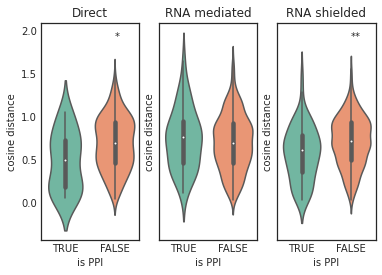

In [157]:
f, axes = plt.subplots(1,3, sharey = True)
i = 0
for name, group in kris.groupby(by = 'Interaction_type'):
    # filter self interaction
    group = group[group['Bait']!=group['Prey']]


    itxn_pairs_kr, non_itxn_pair_kr = generate_pairs_kris(group, colnames = ['Bait', 'Prey'])
    group_data = compare_pair_distance(itxn_pairs_kr, non_itxn_pair_kr, dist_ma = cosine, metaden=df)
    violinplot_w_pval(group_data, axes[i], name)
    i+=1